In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import csv
import hashlib
import logging
import pandas as pd
import zipfile
from pathlib import Path

import torch
import numpy as np
import pytorch_lightning as pl

from movie_lens_25m import MovieLens25MDataModule

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [4]:
class MF(pl.LightningModule):
    def __init__(self, n_users: int, n_movies: int, factors: int = 40, learning_rate: float = 0.001):
        super().__init__()
        
        self.learning_rate = learning_rate
        
        self.user_embed = torch.nn.Embedding(num_embeddings=n_users, embedding_dim=factors)
        self.movie_embed = torch.nn.Embedding(num_embeddings=n_movies, embedding_dim=factors)
        
    def forward(self, x):
        return (self.user_embed(x[:, 0]) * self.movie_embed(x[:, 1])).sum(dim=1)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.mse_loss(y_hat, y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        return self.training_step(batch, batch_idx)
    
    def validation_epoch_end(self, validation_step_outputs):
        loss = 0
        for pred in validation_step_outputs:
            loss += pred
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.learning_rate)

In [5]:
data = MovieLens25MDataModule(batch_size=1024)
data.prepare_data()
data.setup(head=int(1e6))

INFO:root:ml-25m exists, skipping download


In [6]:
mf = MF(
    n_users=data.train.max_user_idx + 1, 
    n_movies=data.train.max_movie_idx + 1
)

In [7]:
trainer = pl.Trainer(
    gpus=1,
    auto_lr_find=True
)

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [8]:
#trainer.tune(mf, data)


  | Name        | Type      | Params
------------------------------------------
0 | user_embed  | Embedding | 269 K 
1 | movie_embed | Embedding | 8.4 M 
------------------------------------------
8.6 M     Trainable params
0         Non-trainable params
8.6 M     Total params
INFO:lightning:
  | Name        | Type      | Params
------------------------------------------
0 | user_embed  | Embedding | 269 K 
1 | movie_embed | Embedding | 8.4 M 
------------------------------------------
8.6 M     Trainable params
0         Non-trainable params
8.6 M     Total params
Finding best initial lr:  96%|█████████▋| 965/1000 [00:12<00:00, 75.90it/s]
LR finder stopped early due to diverging loss.
INFO:lightning:LR finder stopped early due to diverging loss.
<ipython-input-9-85932746b1cc>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


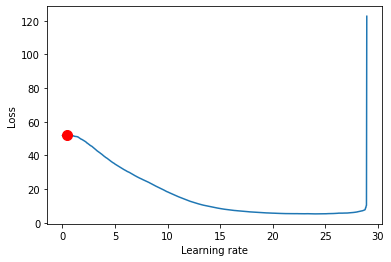

In [9]:
# Run learning rate finder
lr_finder = trainer.tuner.lr_find(mf, data, num_training=1000, max_lr=30, mode="linear")

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

In [10]:
mf.learning_rate = 5

In [ ]:
trainer.fit(mf, datamodule=data)


  | Name        | Type      | Params
------------------------------------------
0 | user_embed  | Embedding | 269 K 
1 | movie_embed | Embedding | 8.4 M 
------------------------------------------
8.6 M     Trainable params
0         Non-trainable params
8.6 M     Total params
INFO:lightning:
  | Name        | Type      | Params
------------------------------------------
0 | user_embed  | Embedding | 269 K 
1 | movie_embed | Embedding | 8.4 M 
------------------------------------------
8.6 M     Trainable params
0         Non-trainable params
8.6 M     Total params


Epoch 1:  99%|█████████▉| 964/971 [00:12<00:00, 74.21it/s, loss=3.87, v_num=22, val_loss=108]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 964/971 [00:13<00:00, 70.68it/s, loss=1.67, v_num=22, val_loss=63]
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 964/971 [00:13<00:00, 70.83it/s, loss=1.22, v_num=22, val_loss=45.7]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 964/971 [00:14<00:00, 67.98it/s, loss=1.03, v_num=22, val_loss=40.3]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 964/971 [00:15<00:00, 64.19it/s, loss=0.929, v_num=22, val_loss=37.6]
Validating: 0it [00:00, ?it/s]
Epoch 6:  88%|████████▊ | 851/971 [00:12<00:01, 66.67it/s, loss=0.917, v_num=22, val_loss=36]